# Map collection
Simple notebook exploring how we can use camera images + position and orientation to capture a map image.

In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skvideo.io
import cv2
import scipy.ndimage
from matplotlib import animation, rc
import fisheye
import encoder_math
from collections import namedtuple
%matplotlib inline

# Data
Load data and get key fields. Main stuff needed for this is orientation (heading is x), and the encoder values as difference vectors.

In [29]:
def get_frame(timestamp, fps=30):
    return np.round(timestamp / (1.0 / fps)).astype(int)

In [137]:
df = pd.read_csv('C:/Users/corey/Desktop/output.csv')
df['timestamp'] = df['timestamp'] - df['timestamp'].min()
df['encoder0_count'] = df['encoder0_count'] - df['encoder0_count'].min()
df['encoder1_count'] = df['encoder1_count'] - df['encoder1_count'].min()
df['encoder0_diff'] = df['encoder0_count'].diff()
df['encoder1_diff'] = df['encoder1_count'].diff()
df['frame'] = get_frame(df['timestamp'])
df

,timestamp,orientation_x,orientation_y,orientation_z,acceleration_x,acceleration_y,acceleration_z,radio_steering_pwm,radio_throttle_pwm,encoder0_count,encoder1_count,steering_servo_voltage,encoder0_diff,encoder1_diff,frame
0,0.0000,357.4375,-4.5000,-1.8750,-0.02,-0.10,0.27,368,202,0,0,490,NaN,NaN,0
1,0.0270,357.5000,-4.5000,-1.8750,-0.02,-0.11,0.26,368,202,0,0,490,0.0,0.0,1
2,0.0501,357.5625,-4.4375,-1.9375,-0.04,-0.12,0.28,368,202,0,0,491,0.0,0.0,2
3,0.0841,357.6250,-4.4375,-2.1250,-0.02,-0.13,0.27,368,202,0,0,484,0.0,0.0,3
4,0.1192,357.7500,-4.3750,-2.0000,-0.07,-0.18,0.26,368,202,0,0,483,0.0,0.0,4
5,0.1510,357.8125,-4.3125,-2.1250,-0.01,-0.09,0.28,368,202,0,0,471,0.0,0.0,5
6,0.1830,357.8750,-4.4375,-2.1250,-0.06,-0.22,0.27,368,202,0,0,475,0.0,0.0,5
7,0.2171,357.8125,-4.5000,-2.1250,-0.03,-0.09,0.21,368,202,0,0,470,0.0,0.0,7
8,0.2488,357.6250,-4.4375,-2.1250,-0.02,-0.16,0.26,368,202,0,0,470,0.0,0.0,7
9,0.2849,357.5000,-4.3750,-2.1250,-0.27,-0.05,0.36,368,202,0,0,477,0.0,0.0,9


# Load video
Load video and explore sample image. Make sure timestamps are matching for video frames.

In [6]:
filename = 'C:/Users/corey/Desktop/output.mp4'
videodata = skvideo.io.vread(filename)
print(videodata.shape)

(900, 480, 640, 3)


In [15]:
df.iloc[10,:].timestamp

0.31700000000000728

timestamp                   0.0000
orientation_x             357.4375
orientation_y              -4.5000
orientation_z              -1.8750
acceleration_x             -0.0200
acceleration_y             -0.1000
acceleration_z              0.2700
radio_steering_pwm        368.0000
radio_throttle_pwm        202.0000
encoder0_count              0.0000
encoder1_count              0.0000
steering_servo_voltage    490.0000
frame                       0.0000
Name: 0, dtype: float64


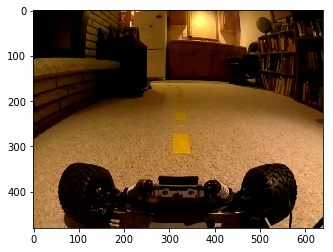

In [52]:
i = 0 # change this to get a different data row and corresponding frame
r = df.iloc[i,:]
print(r)
img = videodata[int(r.frame),:,:,:]
plt.imshow(img)

# Correct for camera distortion
Use separately trained model for removing fisheye lens camera distortion.

In [60]:
NX, NY = 9, 6
fe = fisheye.load_model('./calib.dat')

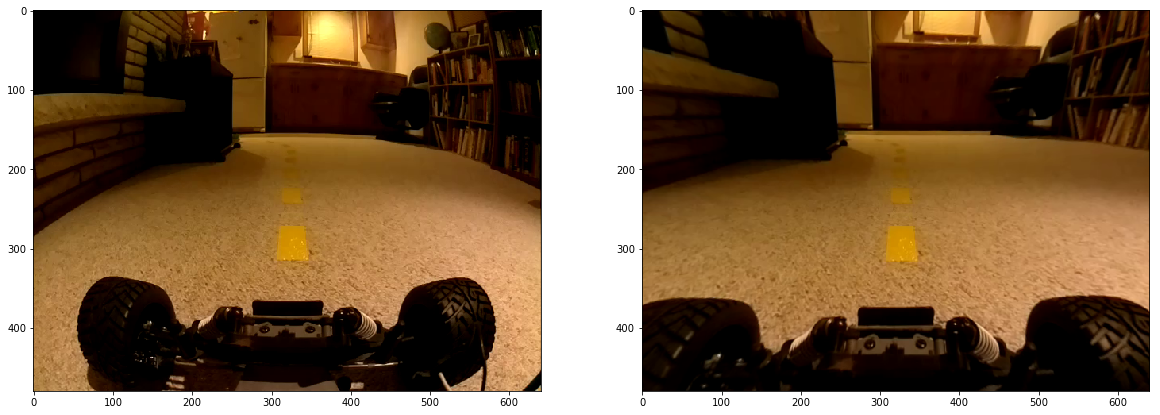

In [70]:
undist_img = fe.undistort(img, undistorted_size=(640, 480))
plt.imsave('C:/Users/corey/Desktop/undist_img.jpg', undist_img)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(undist_img)

# Find perspective rectification matrix
Use homography function with manually identified points to transform from camera view to birdseye view. I used pylons and a measuring tape to help identify the points. Need some improvement here to make this easier.

In [86]:
src_pts = np.array([[719,836],
                    [904,471],
                    [1000,471],
                    [1254,836]]) / 3.0
dst_pts = np.array([[850,1900],
                    [850,100],
                    [1110,100],
                    [1110,1900]]) / 3.0
print(src_pts)
print(dst_pts)
M2, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
M2

[[ 239.66666667  278.66666667]
 [ 301.33333333  157.        ]
 [ 333.33333333  157.        ]
 [ 418.          278.66666667]]
[[ 283.33333333  633.33333333]
 [ 283.33333333   33.33333333]
 [ 370.           33.33333333]
 [ 370.          633.33333333]]


array([[ -5.52614778e-01,  -2.45299285e+00,   4.93829120e+02],
       [  5.31190955e-16,  -5.86330767e+00,   9.13737892e+02],
       [  9.58356375e-19,  -7.66905990e-03,   1.00000000e+00]])

Sample warped image. Turns out to be pretty good representation of ground plane. Checked it out with measuring tape and various manually identified points.

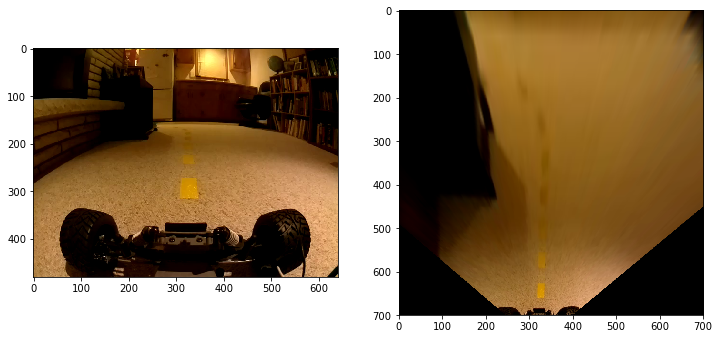

In [270]:
warped = cv2.warpPerspective(undist_img, M2, (700,700))
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(warped)

Sample showing original + undistored + warped side by side.

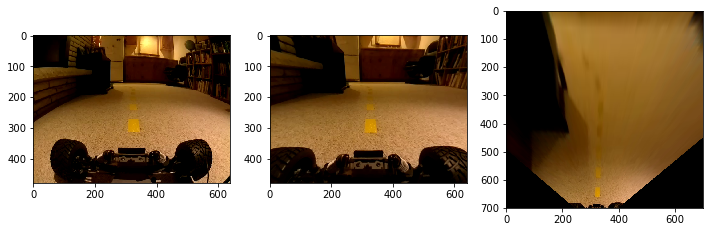

In [334]:
i = 0
img = videodata[int(df.iloc[i,:].frame),:,:,:]
undist_img = fe.undistort(img, undistorted_size=(640, 480))
warped = cv2.warpPerspective(undist_img, M2, (700,700))
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(undist_img)
plt.subplot(1,3,3)
plt.imshow(warped)
plt.imsave('C:/Users/corey/Desktop/warped.png', warped)

# Affine transformation to prepare for map
Experiment using heading to rotate image so it can be pasted on a map. I think the negative is needed on heading because my IMU must be on backwards I guess. Anyway - seems to match up with it.

timestamp                   29.905000
orientation_x              146.375000
orientation_y                0.187500
orientation_z                3.375000
acceleration_x              -0.770000
acceleration_y              -0.510000
acceleration_z              -0.120000
radio_steering_pwm         368.000000
radio_throttle_pwm         202.000000
encoder0_count            1338.000000
encoder1_count            1175.000000
steering_servo_voltage     416.000000
encoder0_diff                1.000000
encoder1_diff                1.000000
frame                      897.000000
x                          371.822739
y                          910.809259
Name: 718, dtype: float64


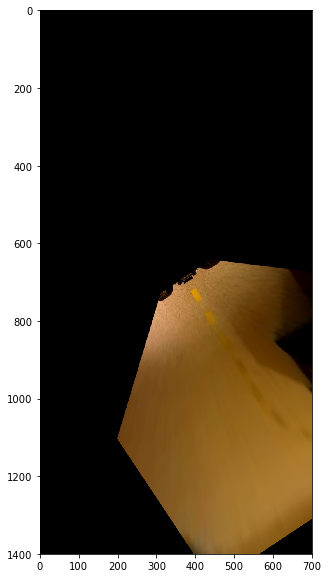

In [272]:
rows,cols,_ = warped.shape
print(df.iloc[i,:])
M = cv2.getRotationMatrix2D((350,700),-(df.iloc[i,:].orientation_x),1)
dst = cv2.warpAffine(warped,M,(700,1400))
plt.figure(figsize=(10,10))
plt.imshow(dst[:,:,:])

In [206]:
np.dot(M, [350.0,700.0,1.0])

array([ 350.,  700.])

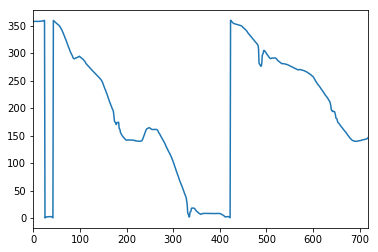

In [119]:
df.orientation_x.plot()

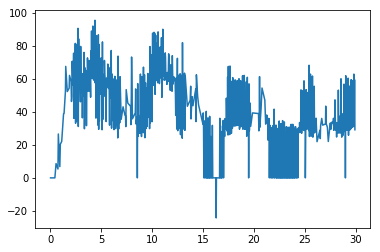

In [126]:
plt.plot(df.timestamp, df.encoder1_count.diff()/df.timestamp.diff())

Timespikes likely due to write hangs from SD card. Likely causing significant drift - need to fix.

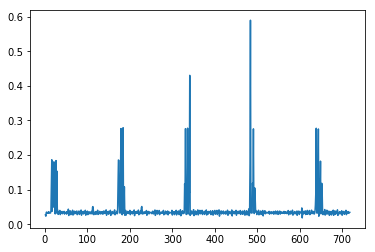

In [125]:
plt.plot(df.timestamp.diff())

# Plot path from encoders
Encoders give distance traveled per tick. We can interpret that as hypotenuse and use sin and cos on IMU heading to get x and y distance per tick. Below is an example driving around part of my home track.

In [ ]:
src_pts = np.array([[719,836],
                    [904,471],
                    [1000,471],
                    [1254,836]])
dst_pts = np.array([[850,1900],
                    [850,100],
                    [1110,100],
                    [1110,1900]])
print(src_pts)
print(dst_pts)
M2, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
M2

1127.51512917 1475.46392084


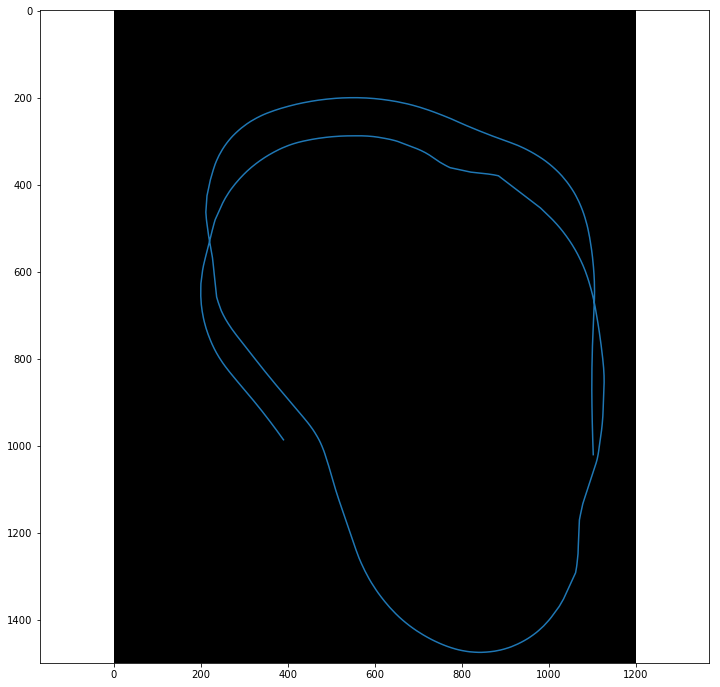

In [362]:
points = []
curr_heading = 0
x, y = 0.0, 0.0
pix_per_tick = 4.0
meters_per_revolution = 0.315
ticks_per_revolution = 20
meters_per_tick = meters_per_revolution / ticks_per_revolution
pixels_per_meter = 104.0 / 0.370
for i,r in df.iterrows():
    if i == 0:
        points.append([x,y])
    else:
        approximate_ticks = (r.encoder0_diff + r.encoder1_diff) / 2
        dist_meters = approximate_ticks * meters_per_tick
        x += np.sin(curr_heading) * dist_meters
        y += np.cos(curr_heading) * dist_meters
        points.append([x,y])
    curr_heading = np.deg2rad(r.orientation_x)
points = np.array(points)    
df['x'] = points[:,0]
df['y'] = points[:,1]
df['px'] = df['x'] * pixels_per_meter
df['py'] = df['y'] * pixels_per_meter
df.px = df.px - df.px.min() + 200
df.py = df.py - df.py.min() + 200
df.py = df.py.max() - df.py + 200
map_width = df.px.max()
map_height = df.py.max()
print(map_width, map_height)
map_img = np.zeros((1500, 1200, 3))
plt.figure(figsize=(12,12))
plt.axis('equal')
plt.imshow(map_img)
plt.plot(df.px, df.py)

# Attempt with wheel encoder distances only (no IMU)

1141.8770928 1530.39162269


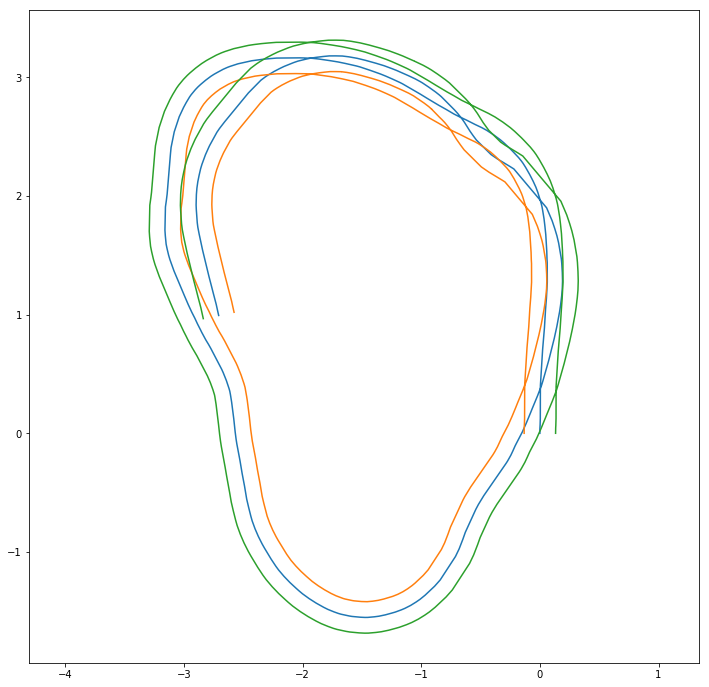

In [453]:
import importlib
importlib.reload(encoder_math)
points = []
curr_heading = 0
x, y = 0.0, 0.0
pix_per_tick = 4.0
meters_per_revolution = 0.315
ticks_per_revolution = 20
meters_per_tick = meters_per_revolution / ticks_per_revolution
pixels_per_meter = 104.0 / 0.370
vehicle_width = 0.265
half_vehicle_width = vehicle_width / 2.0
center_position = np.array([x, y])
half_width_offset_vec = np.array([vehicle_width / 2.0, 0.0])
left_position = center_position - half_width_offset_vec
right_position = center_position + half_width_offset_vec
left_points = []
right_points = []
for i,r in df.iterrows():
    if i == 0:
        points.append(center_position)
        left_points.append(left_position)
        right_points.append(right_position)
    else:
        right_distance = r.encoder0_diff * meters_per_tick
        left_distance = r.encoder1_diff * meters_per_tick
        left_position, center_position, right_position = [np.array(x) for x in encoder_math.apply_distance(half_vehicle_width, left_position, center_position, right_position, left_distance, right_distance)]
        points.append(np.array(center_position))
        left_points.append(np.array(left_position))
        right_points.append(np.array(right_position))
    curr_heading = np.deg2rad(r.orientation_x)
points = np.array(points)    
left_points = np.array(left_points)  
right_points = np.array(right_points)  
df['wx'] = points[:,0]
df['wy'] = points[:,1]
df['lx'] = left_points[:,0]
df['ly'] = left_points[:,1]
df['rx'] = right_points[:,0]
df['ry'] = right_points[:,1]
df['pwx'] = df['wx'] * pixels_per_meter
df['pwy'] = df['wy'] * pixels_per_meter
df.pwx = df.pwx - df.pwx.min() + 200
df.pwy = df.pwy - df.pwy.min() + 200
df.pwy = df.pwy.max() - df.pwy + 200
map_width = df.pwx.max()
map_height = df.pwy.max()
print(map_width, map_height)
map_img = np.zeros((1500, 1200, 3))
plt.figure(figsize=(12,12))
plt.axis('equal')
plt.plot(df.wx, df.wy, df.lx, df.ly, df.rx, df.ry)


In [428]:
points

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       ..., 
       [-12.40001635,  59.81808608],
       [-11.63541203,  60.03452835],
       [-11.63067375,  60.01950799]])

In [434]:
df[['orientation_x','encoder0_diff','encoder1_diff','x','y','lx','ly','wx','wy','rx','ry']]

,orientation_x,encoder0_diff,encoder1_diff,x,y,lx,ly,wx,wy,rx,ry
0,357.4375,NaN,NaN,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
1,357.5000,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
2,357.5625,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
3,357.6250,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
4,357.7500,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
5,357.8125,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
6,357.8750,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
7,357.8125,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
8,357.6250,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000
9,357.5000,0.0,0.0,0.000000,0.000000,-0.132500,0.000000,0.000000,0.000000,0.132500,0.000000


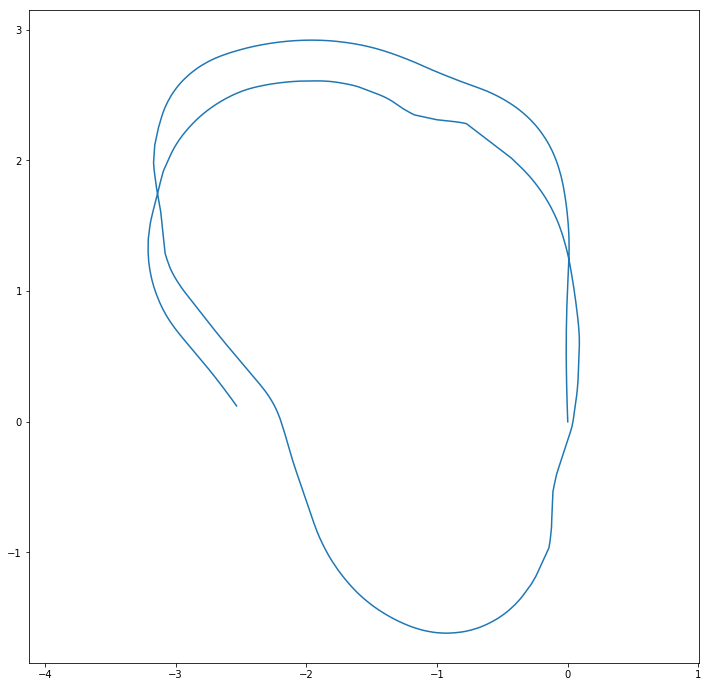

In [283]:
plt.figure(figsize=(12,12))
plt.axis('equal')
plt.plot(df.x, df.y)

# Apply images
We can use the positions to collect undistorted / warped images onto a map image. For now, don't worry about size and just paste a smaller portion. 

Future:
- establish a depth buffer so that portions captured when camera is closer override portions captured while far away
- method to weight multiple image captures together regardless of depth (combine with above somehow)
- image alignment to use this to help with localization (i.e., include in Kalman filter with encoders, etc... for position estimate)
- path optimization, other usage, etc...
- Donkey part version of this

In [291]:
Rect = namedtuple('Rect', 'x1 y1 x2 y2')

In [297]:
warped_size = np.array([700, 700])
persp_size = warped_size * [1, 2]
persp_center = persp_size // 2
print(warped_size)
print(persp_size)
print(persp_center)

[700 700]
[ 700 1400]
[350 700]


In [307]:
np.clip(-10, 1, 20)

1

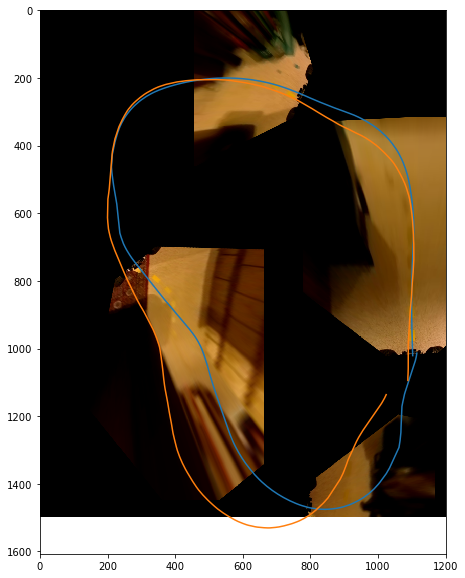

In [442]:

map_size = 1200, 1500
map_img = np.zeros((map_size[1], map_size[0], 3), dtype=np.uint8)
h2 = 50
w2 = 50
n = int(df.shape[0]/2)
warped_size = 700, 700
persp_size = warped_size[0], warped_size[1] * 2
persp_half = persp_size[0] // 2, persp_size[1] // 2
persp_rot_center = (321, 699)
for i in range(0, n, 100):
    rows,cols,_ = warped.shape
    #print(df.iloc[i,:])
    r = df.iloc[i,:]
    img = videodata[int(r.frame),:,:,:]
    undist_img = fe.undistort(img, undistorted_size=(640, 480))
    warped = cv2.warpPerspective(undist_img, M2, warped_size)
    M = cv2.getRotationMatrix2D(persp_rot_center,-int(df.iloc[i,:].orientation_x),1)
    persp = cv2.warpAffine(warped,M,persp_size)
    x, y = int(r.px)+25, int(r.py)
    mx1 = np.clip(x - persp_half[0], 0, map_size[0]-1)
    mx2 = np.clip(x + persp_half[0], 0, map_size[0]-1)
    my1 = np.clip(y - persp_half[1], 0, map_size[1]-1)
    my2 = np.clip(y + persp_half[1], 0, map_size[1]-1)
    px1 = persp_half[0] - (x - mx1)
    px2 = persp_half[0] + (mx2 - x)
    py1 = persp_half[1] - (y - my1)
    py2 = persp_half[1] + (my2 - y)
    try:
        #map_img[my1:my2,mx1:mx2,:] = np.maximum(map_img[my1:my2,mx1:mx2,:], persp[py1:py2,px1:px2,:])
        map_img[my1:my2,mx1:mx2,:] += persp[py1:py2,px1:px2,:] // 1
    except Exception as e:
        print(e)
plt.figure(figsize=(10,10))
plt.imshow(map_img)
plt.plot(df.px[0:n], df.py[0:n], df.pwx[0:n], df.pwy[0:n])


# Simple demo image

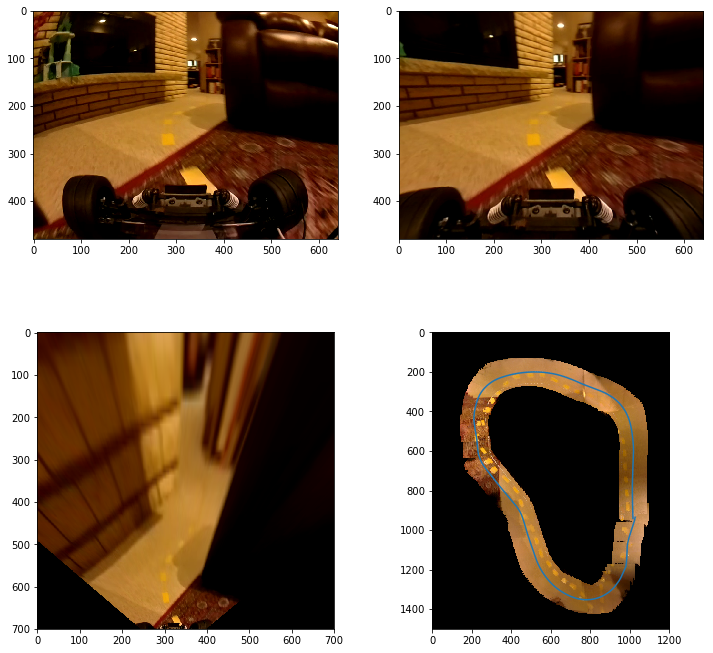

In [266]:
i = 200
img = videodata[int(df.iloc[i,:].frame),:,:,:]
undist_img = fe.undistort(img, undistorted_size=(640, 480))
warped = cv2.warpPerspective(undist_img, M2, (700,700))
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(undist_img)
plt.subplot(2,2,3)
plt.imshow(warped)
plt.subplot(2,2,4)
plt.imshow(map_img)
plt.plot(df.x[0:n], df.y[0:n])